In [1]:
from math import sqrt, isnan
from collections import OrderedDict
import pandas as pd
import numpy as np
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
df = pd.read_csv("gigi.csv", sep = ";", names= ["Name", "Age", "Income"])
df.head()

,Name,Age,Income
0,a,27,70.0
1,b,29,90.0
2,c,29,61.0
3,d,28,60.0
4,e,42,150.0


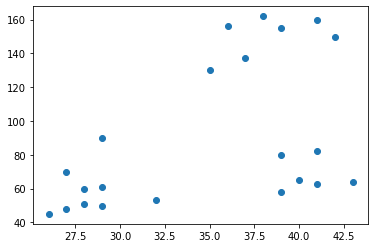

In [3]:
plt.scatter(df["Age"], df["Income"])

In [4]:
km = KMeans(n_clusters=3)
y_pred = km.fit_predict(df[["Age", "Income"]])

In [5]:
df["cluster"] = y_pred
df.head()

,Name,Age,Income,cluster
0,a,27,70.0,1
1,b,29,90.0,2
2,c,29,61.0,1
3,d,28,60.0,1
4,e,42,150.0,0


No handles with labels found to put in legend.


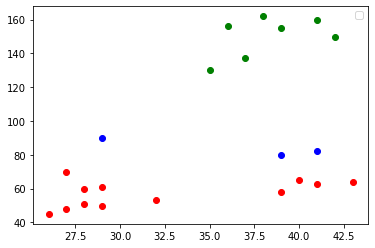

In [6]:
df1 = df[df.cluster == 0]
df2 = df[df.cluster == 1]
df3 = df[df.cluster == 2]

plt.scatter(df1.Age, df1["Income"], color = "green")
plt.scatter(df2.Age, df2["Income"], color = "red")
plt.scatter(df3.Age, df3["Income"], color = "blue")

# plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color= "black", label = "centroid")
plt.legend()

In [7]:
def scale(given, flag):
    lo, hi = min(given[flag]), max(given[flag])
    m = 1 / (hi - lo)
    q = - m * lo

    return [ m * x + q for x in given[flag]]

df["Age_Norm"] = scale(df, "Age")
df["Income_Norm"] = scale(df, "Income")
df

,Name,Age,Income,cluster,Age_Norm,Income_Norm
0,a,27,70.0,1,0.058824,0.213675
1,b,29,90.0,2,0.176471,0.384615
2,c,29,61.0,1,0.176471,0.136752
3,d,28,60.0,1,0.117647,0.128205
4,e,42,150.0,0,0.941176,0.897436
5,f,39,155.0,0,0.764706,0.940171
6,g,41,160.0,0,0.882353,0.982906
7,h,38,162.0,0,0.705882,1.000000
8,i,36,156.0,0,0.588235,0.948718
9,j,35,130.0,0,0.529412,0.726496


No handles with labels found to put in legend.


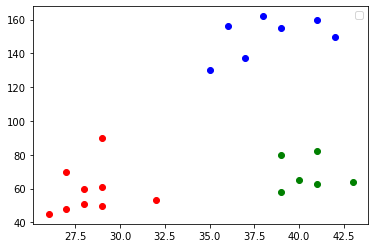

In [8]:
km = KMeans(n_clusters=3)
y_pred = km.fit_predict(df[["Age_Norm", "Income_Norm"]])
df["cluster"] = y_pred

df1 = df[df.cluster == 0]
df2 = df[df.cluster == 1]
df3 = df[df.cluster == 2]

plt.scatter(df1.Age, df1["Income"], color = "green")
plt.scatter(df2.Age, df2["Income"], color = "red")
plt.scatter(df3.Age, df3["Income"], color = "blue")

# plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color= "black", label = "centroid")
plt.legend()

In [9]:
def euclidean_dist(x, y, args):
    val = 0
    for arg in args:
        val += (x[arg] - y[arg]) ** 2
    return sqrt(val)

def nearest(sample, subject, args):
    idx = -1
    dist = float("inf")
    for n, node in enumerate(sample):
        new_eval = euclidean_dist(subject, node, args)
        if new_eval  < dist and new_eval > 0:
            dist = new_eval
            curr = node
            idx = n   
    return idx

def tsp_nearest_neighbour(sample, args, start=0):
    cpy = sample.copy()
    path = [cpy.pop(start)]
    while len(cpy) > 0:
        m = nearest(cpy, path[-1], args)
        path.append(cpy.pop(m))
    return path

def total_dist(sample, args):
    return sum(euclidean_dist(sample[n], sample[n+1], args) for n in range(-1, len(sample) - 1))

def good_tsp_nearest_neighbour(sample, args):
    curr_best = None
    curr_dist = float("inf")
    for n, x in enumerate(sample):
        new_path = tsp_nearest_neighbour(sample, args,start = n)
        new_dist = total_dist(new_path, args)
        if new_dist < curr_dist:
            curr_best = new_path
            curr_dist = new_dist    
    return curr_best
   







In [10]:
def distances(sample, args):
    return [euclidean_dist(sample[n], sample[n + 1], args) for n in range(len(sample) - 1)] + [euclidean_dist(sample[-1], sample[0], args)]

def adjust(original, cluster_indexes):
    sample = original.copy()
    set_backs = 0
    while cluster_indexes[-1] < len(sample) - 1: #as long as there are elements to the right of the last cluster mark
        sample = [sample[-1]] + sample[:-1]
        cluster_indexes = [x + 1 for x in cluster_indexes]
        set_backs += 1
    
    ret_val = []
    curr_cl = 0
    for n in range(len(sample)):
        if n > cluster_indexes[curr_cl]:
            curr_cl += 1
        ret_val.append(curr_cl)
        
    return ret_val[set_backs:] + ret_val[:set_backs]
    
def cluster(original, args, k):
    sample = original.copy()
    enumerated_distances = [(n,d) for n, d in enumerate(distances(sample, args))]
    enumerated_distances.sort(key= lambda x: x[1], reverse=True) #sort by distance
    cluster_indexes = [x[0] for x in enumerated_distances[:k]] #select best k
    cluster_indexes.sort() #sort in indexing order
    return adjust(sample, cluster_indexes)


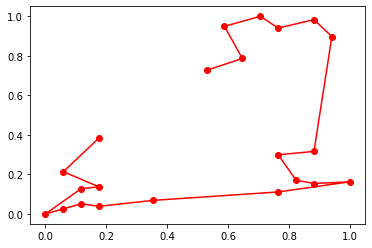

In [11]:
a = []
for n, x in df.iterrows():
    a.append((x["Name"], x["Age_Norm"], x["Income_Norm"]))
    
path = good_tsp_nearest_neighbour(a, [1, 2])
#path = path[2:] + path[0:2]

x_axis = [x[1] for x in path]
y_axis = [x[2] for x in path]
plt.plot(x_axis, y_axis, "ro-")
plt.show()

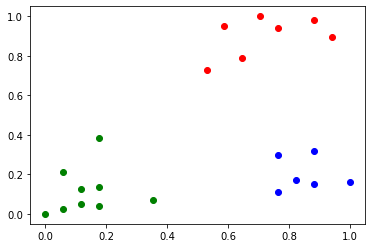

In [12]:
clusters = cluster(path, [1, 2], 3)
to_show = [{"x":path[n][1], "y":path[n][2], "c":clusters[n]} for n in range(len(path))]

cl1 = [x for x in to_show if x["c"] == 0]
cl2 = [x for x in to_show if x["c"] == 1]
cl3 = [x for x in to_show if x["c"] == 2]

plt.scatter(tuple(x["x"] for x in cl1), tuple(x["y"] for x in cl1), color="red")
plt.scatter(tuple(x["x"] for x in cl2), tuple(x["y"] for x in cl2), color="blue")
plt.scatter(tuple(x["x"] for x in cl3), tuple(x["y"] for x in cl3), color="green")

In [13]:
import seaborn as sns
df2 = sns.load_dataset("dots")
df2["val1"] = scale(df2, "coherence")
df2["val2"] = scale(df2, "firing_rate")
df2 = df2[:200]
data_set = [(x["val1"], x["val2"]) for n,x in  df2.iterrows()]

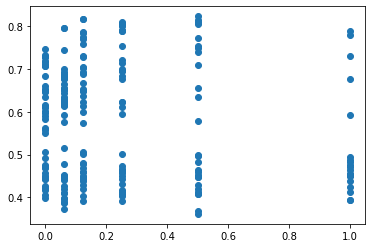

In [14]:
x_axis = [x[0] for x in data_set]
y_axis = [x[1] for x in data_set]
plt.scatter(x_axis, y_axis)

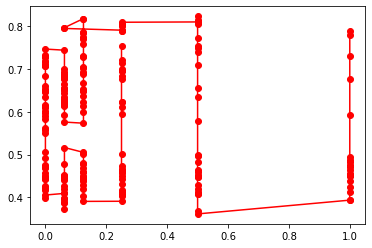

In [15]:
data_set = good_tsp_nearest_neighbour(data_set, (0, 1))
x_axis = [x[0] for x in data_set]
y_axis = [x[1] for x in data_set]
plt.plot(x_axis, y_axis, "ro-")

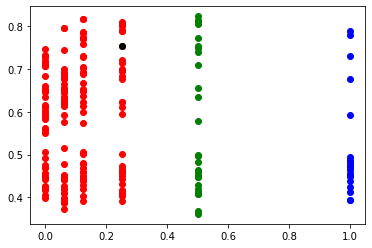

In [16]:
clusters = cluster(data_set, (0, 1), 3)
data_set = [(x[0], x[1], clusters[n]) for n, x in enumerate(data_set)]
plt.scatter(tuple(x[0] for x in data_set if x[2] == 0),tuple(x[1] for x in data_set if x[2] == 0), color= "red")
plt.scatter(tuple(x[0] for x in data_set if x[2] == 1),tuple(x[1] for x in data_set if x[2] == 1), color= "green")
plt.scatter(tuple(x[0] for x in data_set if x[2] == 2),tuple(x[1] for x in data_set if x[2] == 2), color= "blue")
plt.scatter(tuple(x[0] for x in data_set if x[2] == 3),tuple(x[1] for x in data_set if x[2] == 3), color= "purple")
#plt.scatter(tuple(x[0] for x in data_set if x[2] == 4),tuple(x[1] for x in data_set if x[2] == 4), color= "yellow")

plt.scatter([data_set[0][0]],[data_set[0][1]], color="black")

plt.show()

In [17]:
def stars_and_bars(n, k, curr, ls):
    if len(curr) == k:
        ls.append(curr)
        return
    for x in range(max(curr) + 1 if len(curr) > 0 else 0, n - k + len(curr) + 1):
        stars_and_bars(n, k, curr.copy() + [x], ls)

In [18]:
def cluster_2(original, args, k):
    sample = original.copy()
    curr_best = None
    curr_avg_dist = 0
    ls = []
    stars_and_bars(len(sample), k, [], ls)
    for cluster_indexes in ls:
        new_avg_dist = 0
        cluster_beloning_array = adjust(sample, cluster_indexes)
        for cluster in range(k):
            elements_in_cluster = [x for n, x in enumerate(sample) if cluster_beloning_array[n] == cluster]
            elements_not_in_cluster = [y for n,y in enumerate(sample) if cluster_beloning_array[n] != cluster]
            for x in elements_in_cluster:
                for y in elements_not_in_cluster:
                    new_avg_dist += euclidean_dist(x, y, args)
        if new_avg_dist > curr_avg_dist:
            curr_best = cluster_beloning_array
            curr_avg_dist = new_avg_dist
        return curr_best


In [19]:
df3 = pd.read_csv("prova.txt", sep = "    ", names= ["x", "y"])
data_set = [(x["x"], x["y"]) for n,x in df3.iterrows()]
data_set = data_set[:20]
data_set2 = data_set.copy()


<ipython-input-19-ec975d90542d>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df3 = pd.read_csv("prova.txt", sep = "    ", names= ["x", "y"])


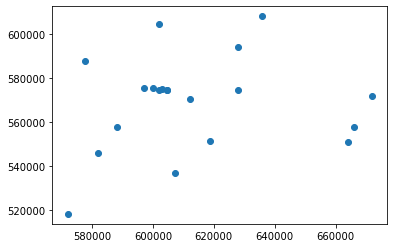

In [20]:
x_axis = [x[0] for x in data_set]
y_axis = [x[1] for x in data_set]
plt.scatter(x_axis, y_axis)

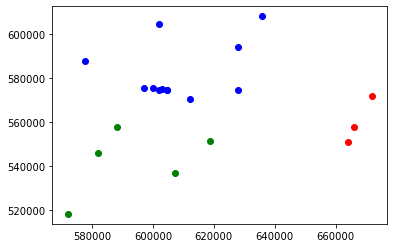

In [21]:
km = KMeans(n_clusters=3)
y_pred = km.fit_predict(data_set)
to_show = [(x[0], x[1], y_pred[n]) for n,x in enumerate(data_set)]
plt.scatter(tuple(x[0] for x in to_show if x[2] == 0),tuple(x[1] for x in to_show if x[2] == 0), color= "red")
plt.scatter(tuple(x[0] for x in to_show if x[2] == 1),tuple(x[1] for x in to_show if x[2] == 1), color= "blue")
plt.scatter(tuple(x[0] for x in to_show if x[2] == 2),tuple(x[1] for x in to_show if x[2] == 2), color= "green")

[(607269, 536961, 0), (618600, 551446, 0), (612184, 570393, 0), (604737, 574591, 0), (604678, 574577, 0), (603145, 574795, 0), (602013, 574722, 0), (600032, 575310, 0), (597173, 575538, 0), (588100, 557588, 0), (582015, 546191, 0), (572029, 518313, 0), (577728, 587566, 1), (601967, 604428, 1), (627912, 593892, 1), (635690, 608046, 1), (627968, 574625, 1), (665845, 557965, 2), (664159, 550946, 2), (671919, 571761, 2)]


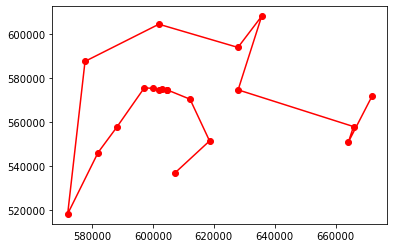

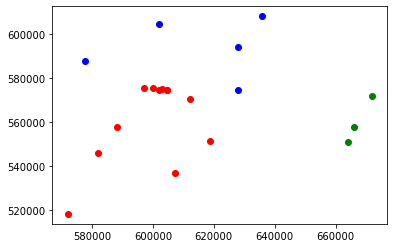

In [22]:
data_set2 = good_tsp_nearest_neighbour(data_set2, (0, 1))
y_pred = cluster(data_set2, (0, 1), 3)
to_show = [(x[0], x[1], y_pred[n]) for n,x in enumerate(data_set2)]
print(to_show)
plt.plot(tuple(x[0] for x in data_set2), tuple(x[1] for x in data_set2), "ro-")
plt.show()
plt.scatter(tuple(x[0] for x in to_show if x[2] == 0),tuple(x[1] for x in to_show if x[2] == 0), color= "red")
plt.scatter(tuple(x[0] for x in to_show if x[2] == 1),tuple(x[1] for x in to_show if x[2] == 1), color= "blue")
plt.scatter(tuple(x[0] for x in to_show if x[2] == 2),tuple(x[1] for x in to_show if x[2] == 2), color= "green")
plt.scatter(tuple(x[0] for x in to_show if x[2] == 3),tuple(x[1] for x in to_show if x[2] == 3), color= "black")

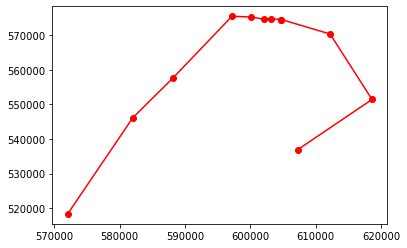

In [23]:
plt.plot(tuple(x[0] for x in to_show if x[2] == 0),tuple(x[1] for x in to_show if x[2] == 0), "ro-")
plt.show()

In [24]:
def ciro(ls, result):
    n=0
    arr = []
    for i,x in enumerate(ls):
        print(f"{arr}  {result}")
        arr.append(n)
        if i == result[n]:
            n = (n+1) % len(result)
        
    return arr
print(ciro([i for i in range(5)],[1,3 ]))

[]  [1, 3]
[0]  [1, 3]
[0, 0]  [1, 3]
[0, 0, 1]  [1, 3]
[0, 0, 1, 1]  [1, 3]
[0, 0, 1, 1, 0]
